In [51]:
import re
import requests
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#Country cleaner corrects any spelling mistakes in the country columns.
from country_cleaner import country_clean


In [52]:
#### Importing csv data files into dataframes 
#####Erase stuff after pound before turning in.
df = pd.read_csv('Input_Data/education_expenditure_supplementary_data.csv')#Public and private direct expenditures on education institutions as a percentage of gross domestic product
df1 = pd.read_csv('Input_Data/educational_attainment_supplementary_data.csv')#refined list of survey questions by country ########country_name erase this line
df2 = pd.read_csv('Input_Data/school_and_country_table.csv')###Not used
df4 = pd.read_csv('Input_Data/timesData.csv')###Not Used
df_GDP = pd.read_csv('Input_Data/GDP.csv')#Country Name
df_GDP2 = pd.read_csv('Input_Data/GDP.csv')
higherED_df = pd.read_csv('Input_data/cwurData.csv')

### All DFS pass through Country Cleaner.
###Checks to see if there is a country column in the dataframe.  If there is a country column in the dataframe
###the County Cleaner tries to correct spelling mistakes and/or updates the name of the country
country_list = [df, df1, df2, df4, df_GDP, df_GDP2, higherED_df]
country_name_list = ['country','country_name','Country Name', 'Country']



for frame in country_list:
    frame.rename(columns=lambda x: x.strip())
    for col in frame.columns:
        if col in country_name_list:
            frame[col] = frame[col].apply(lambda x: country_clean(x))
            
test_df = df.loc[df['country'] == 'United States of America']
df4.head()


,world_rank,university_name,country,teaching,international,research,citations,income,total_score,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,98.7,98.8,34.5,96.1,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,98.0,99.9,83.7,96.0,"2,243",6.9,27%,33 : 67,2011
2,3,Massachusetts Institute of Technology,United States of America,97.8,82.3,91.4,99.9,87.5,95.6,"11,074",9.0,33%,37 : 63,2011
3,4,Stanford University,United States of America,98.3,29.5,98.1,99.2,64.3,94.3,"15,596",7.8,22%,42 : 58,2011
4,5,Princeton University,United States of America,90.9,70.3,95.4,99.9,-,94.2,"7,929",8.4,27%,45 : 55,2011


In [53]:
### pound added so I can find this easier in GIT ###
#############################################################
### Cleaning Higher Ed Data.  We take the top nationally ranked colleges from each country and average the data
rank_one_df = higherED_df[higherED_df['national_rank'] <= 1]


sorted_rank_df = rank_one_df.sort_values(['score','country'],ascending = (False,False))
drop_institution_df = sorted_rank_df.drop(columns=['institution','year'],axis =1)

###Swap columns
first_column = drop_institution_df.pop('country')
drop_institution_df.insert(0, 'country', first_column)

###Get mean and round to remove uncessary zeros.
mean_df = grouped_df = drop_institution_df.groupby(by=['country']).mean().round(2)

h_ed_df= mean_df.copy()

h_ed_df.head()




,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
country,,,,,,,,,,,
Argentina,372.50,1.0,159.0,488.5,178.0,272.00,349.00,342.00,346.5,804.00,45.52
Australia,91.75,1.0,108.5,139.5,132.5,55.75,102.75,74.25,89.0,67.25,48.04
Austria,214.00,1.0,195.5,172.5,100.5,228.00,150.50,155.50,196.0,704.00,47.40
Belgium,88.00,1.0,361.0,213.5,214.0,44.00,101.50,64.00,52.5,69.00,51.88
Brazil,131.50,1.0,299.5,70.5,214.0,60.50,184.00,125.00,163.0,723.50,49.56


In [54]:
#Cleaning GDP file and averaging out years 2001 through 2011. This will help smooth out missing data and lag between school investments vs results 
df_GDP.rename({'Country Name': 'country'}, axis=1, inplace=True)
df_GDP['avg_2000_2011'] = df_GDP[['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009', '2010','2011']].mean(axis=1)
df_GDP = df_GDP[['country', 'Country Code','Indicator Name', 'Indicator Code','avg_2000_2011']]
df_GDP.dropna(subset=['avg_2000_2011'],inplace=True)
df_GDP.reset_index(inplace=True,drop=True)
df_GDP.head()


,country,Country Code,Indicator Name,Indicator Code,avg_2000_2011
0,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,5.373832e+13
1,High income,HIC,GDP (current US$),NY.GDP.MKTP.CD,3.805390e+13
2,OECD members,OED,GDP (current US$),NY.GDP.MKTP.CD,3.787817e+13
3,Post-demographic dividend,PST,GDP (current US$),NY.GDP.MKTP.CD,3.594110e+13
4,IDA & IBRD total,IBT,GDP (current US$),NY.GDP.MKTP.CD,1.618787e+13


In [55]:
#Cleaning school expenditure file. This file is missing many countries (only has around 30)
#Filtering on school spend and creating dataframe for each by category - e.g. All, k_12, and hihger education
#We may be able to run test on all 3 of these groups 
df['institute_type'] = df['institute_type'].str.strip()
df['direct_expenditure_type'] = df['direct_expenditure_type'].str.strip()

df[['1995','2000','2005','2009','2010','2011']] = df[['1995','2000','2005','2009','2010','2011']]/100
df['school_spend_2000_2011'] = df[['2000','2005','2009', '2010','2011']].mean(axis=1)

df = df[df['direct_expenditure_type']== 'Total']
df = df[['country', 'institute_type','school_spend_2000_2011']]

df_all_edu = df[df['institute_type']=='All Institutions']
df_k_12_edu = df[df['institute_type']=='Elementary and Secondary Institutions']
df_higher_edu = df[df['institute_type']=='Higher Education Institutions']

df_all_edu = df_all_edu.dropna(subset=['school_spend_2000_2011'])
df_k_12_edu = df_k_12_edu.dropna(subset=['school_spend_2000_2011'])
df_higher_edu = df_higher_edu.dropna(subset=['school_spend_2000_2011'])

df_all_edu.reset_index(inplace=True,drop=True)
df_k_12_edu.reset_index(inplace=True,drop=True)
df_higher_edu.reset_index(inplace=True,drop=True)

df_all_edu.head()
df_k_12_edu.head()
df_higher_edu.head()

#df.institute_type.unique()

,country,institute_type,school_spend_2000_2011
0,OECD Average,Higher Education Institutions,0.016
1,Australia,Higher Education Institutions,0.016
2,Austria,Higher Education Institutions,0.015
3,Belgium,Higher Education Institutions,0.014
4,Chile,Higher Education Institutions,0.024


In [56]:
#Merging GDP and expenditure data. The column "school expenditures will be the $$$ spend on schooling"
df_all_edu_1 = df_GDP.merge(df_all_edu, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
df_k_12_edu_1 = df_GDP.merge(df_k_12_edu, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
df_higher_edu_1 = df_GDP.merge(df_higher_edu, on='country', how='left').dropna(subset=['school_spend_2000_2011'])

df_all_edu_1.reset_index(inplace=True,drop=True)
df_k_12_edu_1.reset_index(inplace=True,drop=True)
df_higher_edu_1.reset_index(inplace=True,drop=True)

df_all_edu_1['school_expenditures'] = round(df_all_edu_1['school_spend_2000_2011'] * df_all_edu_1['avg_2000_2011'],2)
df_k_12_edu_1['school_expenditures'] = round(df_k_12_edu_1['school_spend_2000_2011'] * df_k_12_edu_1['avg_2000_2011'],2)
df_higher_edu_1['school_expenditures'] = round(df_higher_edu_1['school_spend_2000_2011'] * df_higher_edu_1['avg_2000_2011'],2)

df_all_edu_1.head()
df_k_12_edu_1.head()
df_higher_edu_1.head()


,country,Country Code,Indicator Name,Indicator Code,avg_2000_2011,institute_type,school_spend_2000_2011,school_expenditures
0,United States of America,USA,GDP (current US$),NY.GDP.MKTP.CD,1.303684e+13,Higher Education Institutions,0.027,3.519947e+11
1,Japan,JPN,GDP (current US$),NY.GDP.MKTP.CD,4.944989e+12,Higher Education Institutions,0.016,7.911982e+10
2,Germany,DEU,GDP (current US$),NY.GDP.MKTP.CD,2.899084e+12,Higher Education Institutions,0.013,3.768809e+10
3,United Kingdom,GBR,GDP (current US$),NY.GDP.MKTP.CD,2.372315e+12,Higher Education Institutions,0.012,2.846777e+10
4,France,FRA,GDP (current US$),NY.GDP.MKTP.CD,2.206148e+12,Higher Education Institutions,0.015,3.309223e+10


In [57]:
### data cleaning the survey file to narrow in on questions we may want to take a look at. Column "series name"
df1 = df1[df1['Keep or not']==1]
df1['avg_2005_2015'] = df1[['2005', '2006','2007','2008','2009','2010','2011','2012','2013','2015']].mean(axis=1)
df1.dropna(subset=['avg_2005_2015'],inplace=True)
df1.reset_index(inplace=True,drop=True)
df1.head()

,country_name,series_name,Keep or not,1985,1986,1987,1990,1991,1992,1993,...,2006,2007,2008,2009,2010,2011,2012,2013,2015,avg_2005_2015
0,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.50,NaN,NaN,0.66,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.97,NaN,NaN,NaN,NaN,1.620
1,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.57,NaN,NaN,1.87,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.85,NaN,NaN,NaN,NaN,3.530
2,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.28,NaN,NaN,0.42,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.16,NaN,NaN,NaN,NaN,1.080
3,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.16,NaN,NaN,1.49,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.23,NaN,NaN,NaN,NaN,2.915
4,Afghanistan,Barro-Lee: Percentage of population age 15+ wi...,1.0,77.80,NaN,NaN,75.04,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,58.38,NaN,NaN,NaN,NaN,62.055


In [58]:
#cleaning GDP file to use again. As many countries are missing expenditures, we can just use toal GDP vs school responses as well. This will be a broader dataset with more countries.
df_GDP2.rename({'Country Name': 'country'}, axis=1, inplace=True)
df_GDP2['avg_2000_2015'] = df_GDP2[['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009', '2010','2011','2012','2013','2014','2015']].mean(axis=1)
df_GDP2['avg_2000_2015'] = df_GDP2['avg_2000_2015']/1000000000
df_GDP2 = df_GDP2[['country', 'Country Code','Indicator Name', 'Indicator Code','avg_2000_2015']]
df_GDP2.dropna(subset=['avg_2000_2015'],inplace=True)
df_GDP2.reset_index(inplace=True,drop=True)
df_GDP2.head()

,country,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,59517.199213
1,High income,HIC,GDP (current US$),NY.GDP.MKTP.CD,40900.271146
2,OECD members,OED,GDP (current US$),NY.GDP.MKTP.CD,40629.787880
3,Post-demographic dividend,PST,GDP (current US$),NY.GDP.MKTP.CD,38437.087014
4,IDA & IBRD total,IBT,GDP (current US$),NY.GDP.MKTP.CD,19195.578598


In [59]:
#import country_cleaner.country_clean as country_clean
#df_GDP2["Country Name"] = df_GDP2["Country Name"].apply(lambda x: country_clean(x))

In [60]:
# joinning survey data_sets with expenditures dataset for final data sets to beging running test on.
df1.rename({'country_name': 'country'}, axis=1, inplace=True)

complete_expenditures_all = df1.merge(df_all_edu_1, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
complete_expenditures_k_12 = df1.merge(df_k_12_edu_1, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
complete_expenditures_higher_edu = df1.merge(df_higher_edu_1, on='country', how='left').dropna(subset=['school_spend_2000_2011'])


In [61]:
#final data-set with total GDP (not expenditures) to run test on as it will have more datapoints vs above compplete tables
complete_GDP = df1.merge(df_GDP2, on='country', how='left').dropna(subset=['avg_2000_2015'])

In [62]:
complete_GDP.head(5)

,country,series_name,Keep or not,1985,1986,1987,1990,1991,1992,1993,...,2010,2011,2012,2013,2015,avg_2005_2015,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.50,NaN,NaN,0.66,NaN,NaN,NaN,...,1.97,NaN,NaN,NaN,NaN,1.620,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
1,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.57,NaN,NaN,1.87,NaN,NaN,NaN,...,3.85,NaN,NaN,NaN,NaN,3.530,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
2,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.28,NaN,NaN,0.42,NaN,NaN,NaN,...,1.16,NaN,NaN,NaN,NaN,1.080,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
3,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.16,NaN,NaN,1.49,NaN,NaN,NaN,...,3.23,NaN,NaN,NaN,NaN,2.915,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
4,Afghanistan,Barro-Lee: Percentage of population age 15+ wi...,1.0,77.80,NaN,NaN,75.04,NaN,NaN,NaN,...,58.38,NaN,NaN,NaN,NaN,62.055,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438


In [63]:
complete_GDP = complete_GDP[(complete_GDP['series_name']=='Barro-Lee: Average years of total schooling, age 25+, total') |(complete_GDP['series_name']=='Barro-Lee: Average years of total schooling, age 25+, female') | (complete_GDP['series_name']=='Barro-Lee: Percentage of population age 25+ with no education')]
complete_GDP.head()                         

,country,series_name,Keep or not,1985,1986,1987,1990,1991,1992,1993,...,2010,2011,2012,2013,2015,avg_2005_2015,Country Code,Indicator Name,Indicator Code,avg_2000_2015
2,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.28,NaN,NaN,0.42,NaN,NaN,NaN,...,1.16,NaN,NaN,NaN,NaN,1.080,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
3,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.16,NaN,NaN,1.49,NaN,NaN,NaN,...,3.23,NaN,NaN,NaN,NaN,2.915,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
5,Afghanistan,Barro-Lee: Percentage of population age 25+ wi...,1.0,84.62,NaN,NaN,80.70,NaN,NaN,NaN,...,66.02,NaN,NaN,NaN,NaN,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
8,Albania,"Barro-Lee: Average years of total schooling, a...",1.0,6.13,NaN,NaN,7.29,NaN,NaN,NaN,...,9.57,NaN,NaN,NaN,NaN,9.470,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655
9,Albania,"Barro-Lee: Average years of total schooling, a...",1.0,6.75,NaN,NaN,7.83,NaN,NaN,NaN,...,9.85,NaN,NaN,NaN,NaN,9.770,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655


In [64]:
df_pivot=complete_GDP.pivot(index=['country'], columns='series_name',values=['avg_2005_2015'])
df_pivot.columns = df_pivot.columns.droplevel()
modified_df=df_pivot.rename_axis(None,axis=1)
modified_df=modified_df.reset_index()
modified_df_final = modified_df.merge(df_GDP2, on='country', how='left').dropna(subset=['avg_2000_2015'])
modified_df_final

,country,"Barro-Lee: Average years of total schooling, age 25+, female","Barro-Lee: Average years of total schooling, age 25+, total",Barro-Lee: Percentage of population age 25+ with no education,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,Afghanistan,1.080,2.915,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
1,Albania,9.470,9.770,3.185,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655
2,Algeria,4.835,5.570,31.295,DZA,GDP (current US$),NY.GDP.MKTP.CD,133.920615
3,Argentina,9.345,9.370,1.100,ARG,GDP (current US$),NY.GDP.MKTP.CD,345.568498
4,Armenia,10.795,10.835,0.490,ARM,GDP (current US$),NY.GDP.MKTP.CD,7.306080
...,...,...,...,...,...,...,...,...
138,"Venezuela, RB",7.850,7.655,8.460,VEN,GDP (current US$),NY.GDP.MKTP.CD,245.228688
139,Vietnam,6.500,6.945,7.830,VNM,GDP (current US$),NY.GDP.MKTP.CD,96.776592
140,"Yemen, Rep.",1.065,2.230,73.060,YEM,GDP (current US$),NY.GDP.MKTP.CD,24.405175
141,Zambia,5.605,6.460,19.755,ZMB,GDP (current US$),NY.GDP.MKTP.CD,14.815902


In [65]:
modified_df_final.rename({'Barro-Lee: Average years of total schooling, age 25+, female': 'female_25_plus','Barro-Lee: Average years of total schooling, age 25+, total': 'All_25_plus','Barro-Lee: Percentage of population age 25+ with no education': 'All_25_plus_no_edu'}, axis=1, inplace=True)
modified_df_final.head()

,country,female_25_plus,All_25_plus,All_25_plus_no_edu,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,Afghanistan,1.080,2.915,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
1,Albania,9.470,9.770,3.185,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655
2,Algeria,4.835,5.570,31.295,DZA,GDP (current US$),NY.GDP.MKTP.CD,133.920615
3,Argentina,9.345,9.370,1.100,ARG,GDP (current US$),NY.GDP.MKTP.CD,345.568498
4,Armenia,10.795,10.835,0.490,ARM,GDP (current US$),NY.GDP.MKTP.CD,7.306080


In [66]:
modified_df_final['country_id'] = pd.factorize(modified_df_final.country)[0]

In [67]:
modified_df_final.head()

,country,female_25_plus,All_25_plus,All_25_plus_no_edu,Country Code,Indicator Name,Indicator Code,avg_2000_2015,country_id
0,Afghanistan,1.080,2.915,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438,0
1,Albania,9.470,9.770,3.185,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655,1
2,Algeria,4.835,5.570,31.295,DZA,GDP (current US$),NY.GDP.MKTP.CD,133.920615,2
3,Argentina,9.345,9.370,1.100,ARG,GDP (current US$),NY.GDP.MKTP.CD,345.568498,3
4,Armenia,10.795,10.835,0.490,ARM,GDP (current US$),NY.GDP.MKTP.CD,7.306080,4


In [68]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer  ##Is this being used?


X_complete_GDP = modified_df_final[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']]
y_complete_GDP = modified_df_final[['country_id']]
X_complete_GDP

,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015
0,1.080,2.915,68.800,12.328438
1,9.470,9.770,3.185,9.476655
2,4.835,5.570,31.295,133.920615
3,9.345,9.370,1.100,345.568498
4,10.795,10.835,0.490,7.306080
...,...,...,...,...
138,7.850,7.655,8.460,245.228688
139,6.500,6.945,7.830,96.776592
140,1.065,2.230,73.060,24.405175
141,5.605,6.460,19.755,14.815902


In [69]:
X_complete_GDP_normalized = MinMaxScaler().fit(X_complete_GDP).transform(X_complete_GDP)  
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(X_complete_GDP)
kmeans.labels_
modified_df_final['cluster'] = kmeans.fit_predict(X_complete_GDP)
y_kmeans = kmeans.predict(X_complete_GDP)
kmeans.labels_
kmeans.cluster_centers_


array([[7.20852000e+00, 7.58896000e+00, 2.02831600e+01, 9.02871700e+01],
       [1.32750000e+01, 1.32750000e+01, 4.45000000e-01, 1.40743376e+04],
       [9.26300000e+00, 9.48800000e+00, 7.36900000e+00, 2.42373195e+03],
       [9.09200000e+00, 9.54350000e+00, 9.33150000e+00, 1.07619918e+03],
       [8.78000000e+00, 9.16750000e+00, 4.10000000e+00, 4.98019991e+03]])

In [70]:
h_ed_df.describe()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
count,59.000000,59.0,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,353.546610,1.0,229.881017,282.851356,159.900847,369.37678,379.218475,330.740508,396.813559,448.558983,50.004576
std,309.691534,0.0,128.823050,200.200661,73.171126,318.43022,305.787634,242.381348,316.655691,295.852672,10.092858
min,1.000000,1.0,2.500000,3.000000,1.000000,1.00000,1.000000,1.000000,1.000000,4.250000,44.180000
25%,82.000000,1.0,104.625000,103.375000,105.250000,62.75000,118.085000,101.375000,105.250000,181.750000,44.790000
50%,291.500000,1.0,278.000000,213.500000,214.000000,259.50000,247.500000,268.500000,328.000000,483.500000,46.280000
75%,552.000000,1.0,361.000000,522.500000,214.000000,606.75000,683.500000,522.000000,746.250000,756.750000,49.780000
max,971.500000,1.0,361.000000,522.500000,214.000000,998.50000,962.000000,806.000000,956.000000,804.000000,100.000000


In [71]:
h_ed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, Argentina to Uruguay
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   world_rank            59 non-null     float64
 1   national_rank         59 non-null     float64
 2   quality_of_education  59 non-null     float64
 3   alumni_employment     59 non-null     float64
 4   quality_of_faculty    59 non-null     float64
 5   publications          59 non-null     float64
 6   influence             59 non-null     float64
 7   citations             59 non-null     float64
 8   broad_impact          59 non-null     float64
 9   patents               59 non-null     float64
 10  score                 59 non-null     float64
dtypes: float64(11)
memory usage: 5.5+ KB


In [72]:
h_ed_df.corr()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
world_rank,1.000000,NaN,0.597069,0.755904,0.627145,0.920100,0.862065,0.858061,0.908768,0.729807,-0.536188
national_rank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_of_education,0.597069,NaN,1.000000,0.446030,0.845748,0.562158,0.570039,0.548860,0.547861,0.434614,-0.590930
alumni_employment,0.755904,NaN,0.446030,1.000000,0.442705,0.601342,0.549113,0.537933,0.568028,0.561378,-0.539092
quality_of_faculty,0.627145,NaN,0.845748,0.442705,1.000000,0.601272,0.655108,0.646750,0.627308,0.531992,-0.662818
publications,0.920100,NaN,0.562158,0.601342,0.601272,1.000000,0.891539,0.900068,0.953361,0.672824,-0.517084
influence,0.862065,NaN,0.570039,0.549113,0.655108,0.891539,1.000000,0.915437,0.944099,0.696907,-0.526425
citations,0.858061,NaN,0.548860,0.537933,0.646750,0.900068,0.915437,1.000000,0.937196,0.642703,-0.527331
broad_impact,0.908768,NaN,0.547861,0.568028,0.627308,0.953361,0.944099,0.937196,1.000000,0.675042,-0.521284
patents,0.729807,NaN,0.434614,0.561378,0.531992,0.672824,0.696907,0.642703,0.675042,1.000000,-0.564994


In [73]:
h_ed_df.cov()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
world_rank,95908.846416,0.0,23820.292993,46866.371512,14211.410827,90735.795091,81637.409124,64409.036355,89118.831771,66867.167869,-1675.949146
national_rank,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
quality_of_education,23820.292993,0.0,16595.378209,11503.309059,7972.124834,23060.359550,22455.256074,17137.760465,22348.646745,16564.282570,-768.322884
alumni_employment,46866.371512,0.0,11503.309059,40080.304746,6485.141842,38335.507944,33616.094821,26103.150523,36009.923447,33250.367970,-1089.287401
quality_of_faculty,14211.410827,0.0,7972.124834,6485.141842,5354.013711,14009.570053,14657.925958,11470.316715,14534.750678,11516.500709,-489.495313
publications,90735.795091,0.0,23060.359550,38335.507944,14009.570053,101397.805312,86810.999085,69468.620596,96130.005855,63385.721833,-1661.839933
influence,81637.409124,0.0,22455.256074,33616.094821,14657.925958,86810.999085,93506.076968,67849.676080,91416.566262,63047.874195,-1624.689070
citations,64409.036355,0.0,17137.760465,26103.150523,11470.316715,69468.620596,67849.676080,58748.717629,71931.120872,46087.685545,-1290.021742
broad_impact,89118.831771,0.0,22348.646745,36009.923447,14534.750678,96130.005855,91416.566262,71931.120872,100270.826710,63240.236876,-1666.002839
patents,66867.167869,0.0,16564.282570,33250.367970,11516.500709,63385.721833,63047.874195,46087.685545,63240.236876,87528.803468,-1687.071206


In [74]:
#modified_df_final.head()

In [75]:
#modified_df_final.describe()

In [76]:
h_ed_df.reset_index(inplace=True)

In [77]:
a_final_frame = pd.merge(h_ed_df,modified_df_final,how="left",on='country')
a_final_frame = a_final_frame.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

In [78]:
a_final_frame.describe()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster
count,59.000000,59.0,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,353.546610,1.0,229.881017,282.851356,159.900847,369.37678,379.218475,330.740508,396.813559,448.558983,50.004576,9.800000,10.071909,6.323000,949.977995,73.000000,0.854545
std,309.691534,0.0,128.823050,200.200661,73.171126,318.43022,305.787634,242.381348,316.655691,295.852672,10.092858,2.354011,2.121826,9.078826,2096.345879,42.604121,1.352887
min,1.000000,1.0,2.500000,3.000000,1.000000,1.00000,1.000000,1.000000,1.000000,4.250000,44.180000,3.230000,4.925000,0.125000,14.641724,3.000000,0.000000
25%,82.000000,1.0,104.625000,103.375000,105.250000,62.75000,118.085000,101.375000,105.250000,181.750000,44.790000,8.710000,8.832500,0.870000,148.277520,35.500000,0.000000
50%,291.500000,1.0,278.000000,213.500000,214.000000,259.50000,247.500000,268.500000,328.000000,483.500000,46.280000,10.455000,10.590000,2.625000,281.926930,63.000000,0.000000
75%,552.000000,1.0,361.000000,522.500000,214.000000,606.75000,683.500000,522.000000,746.250000,756.750000,49.780000,11.632500,11.665000,8.350000,965.707184,113.500000,2.000000
max,971.500000,1.0,361.000000,522.500000,214.000000,998.50000,962.000000,806.000000,956.000000,804.000000,100.000000,13.275000,13.275000,44.655000,14074.337562,137.000000,4.000000


In [79]:
a_final_frame.corr()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster
world_rank,1.000000,NaN,0.597069,0.755904,0.627145,0.920100,0.862065,0.858061,0.908768,0.729807,-0.536188,-0.306991,-0.332706,0.241208,-0.379818,0.085049,-0.475754
national_rank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_of_education,0.597069,NaN,1.000000,0.446030,0.845748,0.562158,0.570039,0.548860,0.547861,0.434614,-0.590930,-0.447566,-0.468350,0.292016,-0.407331,0.020361,-0.260393
alumni_employment,0.755904,NaN,0.446030,1.000000,0.442705,0.601342,0.549113,0.537933,0.568028,0.561378,-0.539092,0.022248,-0.008384,-0.025533,-0.426992,-0.017255,-0.538518
quality_of_faculty,0.627145,NaN,0.845748,0.442705,1.000000,0.601272,0.655108,0.646750,0.627308,0.531992,-0.662818,-0.468006,-0.494358,0.282506,-0.426576,-0.054162,-0.231646
publications,0.920100,NaN,0.562158,0.601342,0.601272,1.000000,0.891539,0.900068,0.953361,0.672824,-0.517084,-0.381037,-0.410776,0.303742,-0.374576,0.109275,-0.458597
influence,0.862065,NaN,0.570039,0.549113,0.655108,0.891539,1.000000,0.915437,0.944099,0.696907,-0.526425,-0.514956,-0.515373,0.448021,-0.349984,0.121026,-0.333521
citations,0.858061,NaN,0.548860,0.537933,0.646750,0.900068,0.915437,1.000000,0.937196,0.642703,-0.527331,-0.516349,-0.530806,0.450237,-0.353134,0.142496,-0.346006
broad_impact,0.908768,NaN,0.547861,0.568028,0.627308,0.953361,0.944099,0.937196,1.000000,0.675042,-0.521284,-0.494114,-0.506573,0.421581,-0.358956,0.141211,-0.378530
patents,0.729807,NaN,0.434614,0.561378,0.531992,0.672824,0.696907,0.642703,0.675042,1.000000,-0.564994,-0.358445,-0.377446,0.182739,-0.402937,-0.052522,-0.354901


In [80]:
a_final_frame.cov()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster
world_rank,95908.846416,0.0,23820.292993,46866.371512,14211.410827,90735.795091,81637.409124,64409.036355,89118.831771,66867.167869,-1675.949146,-219.601955,-214.522296,665.462219,-2.419583e+05,1101.087593,-195.589714
national_rank,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
quality_of_education,23820.292993,0.0,16595.378209,11503.309059,7972.124834,23060.359550,22455.256074,17137.760465,22348.646745,16564.282570,-768.322884,-136.907276,-129.134351,344.506490,-1.109613e+05,112.722222,-45.777545
alumni_employment,46866.371512,0.0,11503.309059,40080.304746,6485.141842,38335.507944,33616.094821,26103.150523,36009.923447,33250.367970,-1089.287401,10.499506,-3.566196,-46.473005,-1.794532e+05,-147.379630,-146.059869
quality_of_faculty,14211.410827,0.0,7972.124834,6485.141842,5354.013711,14009.570053,14657.925958,11470.316715,14534.750678,11516.500709,-489.495313,-81.837570,-77.919196,190.524298,-6.642808e+04,-171.411481,-23.279798
publications,90735.795091,0.0,23060.359550,38335.507944,14009.570053,101397.805312,86810.999085,69468.620596,96130.005855,63385.721833,-1661.839933,-273.650910,-265.911231,841.309370,-2.395657e+05,1420.347222,-189.284027
influence,81637.409124,0.0,22455.256074,33616.094821,14657.925958,86810.999085,93506.076968,67849.676080,91416.566262,63047.874195,-1624.689070,-367.125028,-331.182414,1231.864890,-2.222010e+05,1561.591296,-136.653461
citations,64409.036355,0.0,17137.760465,26103.150523,11470.316715,69468.620596,67849.676080,58748.717629,71931.120872,46087.685545,-1290.021742,-288.764407,-267.570019,971.097605,-1.758710e+05,1442.264444,-111.208125
broad_impact,89118.831771,0.0,22348.646745,36009.923447,14534.750678,96130.005855,91416.566262,71931.120872,100270.826710,63240.236876,-1666.002839,-360.699352,-333.320290,1186.918454,-2.333537e+05,1865.648148,-158.807744
patents,66867.167869,0.0,16564.282570,33250.367970,11516.500709,63385.721833,63047.874195,46087.685545,63240.236876,87528.803468,-1687.071206,-250.339858,-237.609532,492.219966,-2.506106e+05,-663.879259,-142.451721


In [81]:
###Causal Inference

import statsmodels.api as sm
import statsmodels.formula.api as smf
#from causalinference import CausalModel  Raises error zero control units.  Control units might need to be 0 or 1 exclusively 

In [82]:
### Average NANs in all applicable columns
a_final_frame = a_final_frame.round()
a_final_frame.columns[a_final_frame.isna().any()].tolist()

['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']
a_final_frame[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']] = a_final_frame[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']].fillna(value=a_final_frame[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']].mean())

a_final_frame.head()

,country,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster
0,Argentina,372.0,1.0,159.0,488.0,178.0,272.0,349.0,342.0,346.0,804.0,46.0,9.0,9.0,1.0,346.0,3.0,0.0
1,Australia,92.0,1.0,108.0,140.0,132.0,56.0,103.0,74.0,89.0,67.0,48.0,12.0,12.0,1.0,940.0,5.0,3.0
2,Austria,214.0,1.0,196.0,172.0,100.0,228.0,150.0,156.0,196.0,704.0,47.0,9.0,10.0,2.0,345.0,6.0,0.0
3,Belgium,88.0,1.0,361.0,214.0,214.0,44.0,102.0,64.0,52.0,69.0,52.0,10.0,11.0,5.0,418.0,10.0,0.0
4,Brazil,132.0,1.0,300.0,70.0,214.0,60.0,184.0,125.0,163.0,724.0,50.0,7.0,7.0,14.0,1483.0,15.0,3.0


In [83]:
###Causal Inference  ###Average Treatment Effects

#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from causalinference import CausalModel  Raises error zero control units.  Control units might need to be 0 or 1 exclusively 
###
# This cell generates an error when using the Causal Model.  Values might need to be 0 or 1 exclusively.
# ATE_array = np.array([a_final_frame.quality_of_education,a_final_frame.alumni_employment])
# ATE_array = ATE_array.T.reshape(59,2)

# m=CausalModel(Y=a_final_frame.avg_2000_2015.values, D=a_final_frame.patents.values, X=ATE_array)
# print(a_final_frame[a_final_frame.score==0].shape)
# a_final_frame.score.values
###




                                                                  ##########SLS############

In [84]:
###Notes to be erased.  
'''
Endogenous Variable --  a variable that is determined or changed by the relationships it has with other variables.  Correlates with other variables mainly the dependant variable
Exogenous Variable -- independant variable.  Does not dierctly corelate or have a direct effect
instrument variable -- has no direct correlation between the above and dependant variable.
#a_final_frame['citations']  a_final_frame['broad_impact'])
'''

from linearmodels import IV2SLS

m = IV2SLS(dependent = a_final_frame['female_25_plus'],
           exog=a_final_frame['avg_2000_2015'],
           endog=a_final_frame['score'],
           instruments=a_final_frame['patents'])

iv2sls_1=m.fit(cov_type='robust')

print(iv2sls_1)  ###GDP is significant

                          IV-2SLS Estimation Summary                          
Dep. Variable:         female_25_plus   R-squared:                      0.9530
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9514
No. Observations:                  59   F-statistic:                    820.14
Date:                Sun, Jan 30 2022   P-value (F-stat)                0.0000
Time:                        07:30:01   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
avg_2000_2015    -0.0007     0.0002    -4.3083     0.0000     -0.0010     -0.0004
score             0.2073     0.0088     

In [85]:

mFull = IV2SLS(dependent = modified_df_final['female_25_plus'],
           exog=modified_df_final['avg_2000_2015'],
           endog=None,
           instruments=None)

iv2sls_2=mFull.fit(cov_type='robust')

print(iv2sls_2)  ###GDP is more significant

                            OLS Estimation Summary                            
Dep. Variable:         female_25_plus   R-squared:                      0.1223
Estimator:                        OLS   Adj. R-squared:                 0.1161
No. Observations:                 143   F-statistic:                    7.4551
Date:                Sun, Jan 30 2022   P-value (F-stat)                0.0063
Time:                        07:30:01   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
avg_2000_2015     0.0020     0.0007     2.7304     0.0063      0.0006      0.0034


In [86]:
### SLS prediction is female dependant on average GDP
SLSresults = iv2sls_1.predict()
country_final = a_final_frame[['country','avg_2000_2015']]

SLSframe = [SLSresults, country_final]
15
pred_frame = pd.concat(SLSframe,axis=1,join='outer')


SLSresultsFull = iv2sls_2.predict()
country_final_Full = modified_df_final[['country','avg_2000_2015']]

SLSframe_Full = [SLSresultsFull, country_final_Full]

pred_frame_Full = pd.concat(SLSframe_Full,axis=1,join='outer')


In [87]:
pred_frame_Full.head()

,fitted_values,country,avg_2000_2015
0,0.024709,Afghanistan,12.328438
1,0.018993,Albania,9.476655
2,0.268406,Algeria,133.920615
3,0.692594,Argentina,345.568498
4,0.014643,Armenia,7.306080


In [88]:
pred_frame.head()

,fitted_values,country,avg_2000_2015
0,9.304944,Argentina,346.0
1,9.324535,Australia,940.0
2,9.512892,Austria,345.0
3,10.500766,Belgium,418.0
4,9.378038,Brazil,1483.0


In [89]:
#Naive Bayes
##How would I use this with the data?

#Nearest Neighbors
##NO

##Gaussian

#Neural Net
#Least Squares
#Subset Lasso
#Gradient Boost Tree

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

country_list = a_final_frame['country'].to_list()
le = LabelEncoder()
country_transformed = le.fit_transform(country_list)

country_transformed

label = a_final_frame['score'].to_list()
#label_array = a_final_frame['score'].as_matrix().reshape(1,len(a_final_frame['score']))
label_droped = a_final_frame.drop(['score','country','cluster','national_rank'], axis=1)

avg_list = a_final_frame['avg_2000_2015'].to_list()
world_list = a_final_frame['female_25_plus'].to_list()

#features = zip[avg_list,world_list]
features = list(map(list, zip(avg_list, world_list)))


X_train, X_test, y_train, y_test = train_test_split(features, label,test_size=0.50, random_state=42)

Gaus = GaussianNB()
Gaus.fit(X_train,y_train)

y_pred = Gaus.predict(X_test)

y_pred

array([47., 45., 48., 45., 48., 46., 49., 48., 49., 45., 48., 45., 45.,
       47., 49., 49., 48., 46., 46., 45., 45., 48., 45., 45., 48., 47.,
       49., 48., 45., 47.])

In [91]:
#Multiple linear regression between GDP, word_rank, broad_impact
from sklearn.linear_model import LinearRegression

modified_df_final.head()
a_final_frame.head()

X = a_final_frame[['female_25_plus','quality_of_education']].to_numpy()
y= a_final_frame['avg_2000_2015'].to_numpy()

model = LinearRegression().fit(X, y)

frame_score = model.score(X,y)
y_pred = model.predict(X)
print(y_pred)

[1448.047361   1652.16012392 1205.58955655   80.99686282  610.8104269
  804.32581385 1815.98296477  288.18164781  863.86560732  167.7207511
   37.63491868  124.35880696  429.27372568 1695.52206806  710.64014244
    7.37880181 1957.63861341 2151.71757113 1979.80580561   80.99686282
  621.24365498 1783.2183966    80.99686282  384.53047178 1633.06495379
  210.51912446 2281.23983277 1939.51588355 2272.17846784 1748.34480001
  221.11650043  124.35880696  632.9776191  1328.55890456  839.59883332
 1717.68926026  810.87872748  401.11719062   90.45765063  618.3357808
 2311.49594964  211.08269523  624.88869443  694.46229311  -49.08896959
   -5.72702545 2031.25667442  889.51369109   80.99686282 1658.71303755
 2235.36943734 1787.66228181  211.08269523  297.80658351  341.16852765
   80.99686282 2285.28429511 2303.40702497  207.0382329 ]


In [92]:
##Polynomial Linear Regression
from sklearn.preprocessing import PolynomialFeatures

Xpoly = a_final_frame['quality_of_education'].to_numpy()
Xpoly = Xpoly.reshape((-1,1))

ypoly = a_final_frame['avg_2000_2015'].to_numpy()

X_ = PolynomialFeatures(degree=2,include_bias=False).fit_transform(Xpoly)
poly_model = LinearRegression().fit(X_,y)

y_pred = model.predict(X_)
print(y_pred)

[-1.69678541e+05 -7.82360565e+04 -2.57355453e+05 -8.66755701e+05
 -5.99890592e+05 -3.97834362e+05 -4.58618453e+04 -7.51487133e+05
 -4.79397252e+05 -8.66755701e+05 -8.66755701e+05 -8.66755701e+05
 -5.53132890e+05 -7.82360565e+04 -5.91966584e+05 -8.57232782e+05
 -3.03690667e+04 -1.23407195e+04 -2.16787761e+04 -8.66755701e+05
 -5.23009555e+05 -5.16813961e+04 -8.66755701e+05 -8.66755701e+05
 -1.39245119e+05 -7.16331160e+05  1.41625523e+03 -4.69995438e+04
 -6.08186210e+02 -7.82360565e+04 -7.38205349e+05 -8.66755701e+05
 -5.60794782e+05 -1.80478306e+05 -3.59883776e+05 -6.43034349e+04
 -3.94599731e+05 -7.33804300e+05 -8.66755701e+05 -5.19303114e+05
  9.88779836e+02 -8.66755701e+05 -5.15609780e+05 -5.00967499e+05
 -8.66755701e+05 -8.66755701e+05 -3.22643948e+04 -3.56806415e+05
 -8.66755701e+05 -7.67838181e+04 -3.09260634e+02 -6.97192136e+04
 -8.66755701e+05 -8.66755701e+05 -8.66755701e+05 -8.66755701e+05
 -2.34408858e+01  2.76728258e+03 -8.38344213e+05]


In [93]:
##Sub Set Lasso

higherED_df.head()

,world_rank,institution,country,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,1,Harvard University,United States of America,1,7,9,1,1,1,1,NaN,5,100.00,2012
1,2,Massachusetts Institute of Technology,United States of America,2,9,17,3,12,4,4,NaN,1,91.67,2012
2,3,Stanford University,United States of America,3,17,11,5,4,2,2,NaN,15,89.50,2012
3,4,University of Cambridge,United Kingdom,1,10,24,4,16,16,11,NaN,50,86.17,2012
4,5,California Institute of Technology,United States of America,4,2,29,7,37,22,22,NaN,18,85.21,2012


In [94]:
###LASSO REGRESSION
from sklearn.linear_model import Lasso
higherED_df = higherED_df.fillna(0)

dummy = pd.get_dummies(higherED_df[['institution','country']])

y = higherED_df['score']

X_dropped = higherED_df.drop(['score','institution','country'], axis=1).astype('float64')
dropped_list = X_dropped.columns

dropped_list

dummy.head()
X = pd.concat([X_dropped, dummy[['country_United Kingdom','country_United States of America']]],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

scaler = StandardScaler().fit(X_train[dropped_list]) 

X_train[dropped_list] = scaler.transform(X_train[dropped_list])

X_test[dropped_list] = scaler.transform(X_test[dropped_list])

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)



Lasso(alpha=1)

(0.005821722491960459,
 858.8523425678187,
 -4.430576525113921,
 8.409897626446108)

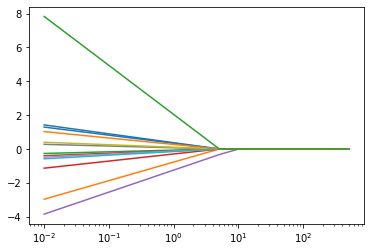

In [95]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)

lasso = Lasso(max_iter=10000)
coefs = []


for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')

In [96]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)
model.alpha_

lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

print(list(zip(lasso_best.coef_, X)))

[(1.3835980219860275, 'world_rank'), (-3.019536178929906, 'national_rank'), (-0.2694202738893198, 'quality_of_education'), (-1.1450661575103949, 'alumni_employment'), (-3.841816638571859, 'quality_of_faculty'), (-0.48188123886721584, 'publications'), (-0.554265924820888, 'influence'), (0.310293222791675, 'citations'), (0.46974781028747553, 'broad_impact'), (-0.5894618335484249, 'patents'), (1.4300822097687707, 'year'), (1.1419395017367564, 'country_United Kingdom'), (7.9798831334807, 'country_United States of America')]


In [97]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, lasso_best.predict(X_test))

26.089078515663918

(2.0, 70.0)

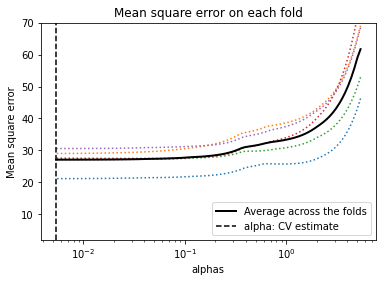

In [98]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 2, 70
plt.ylim(ymin, ymax)

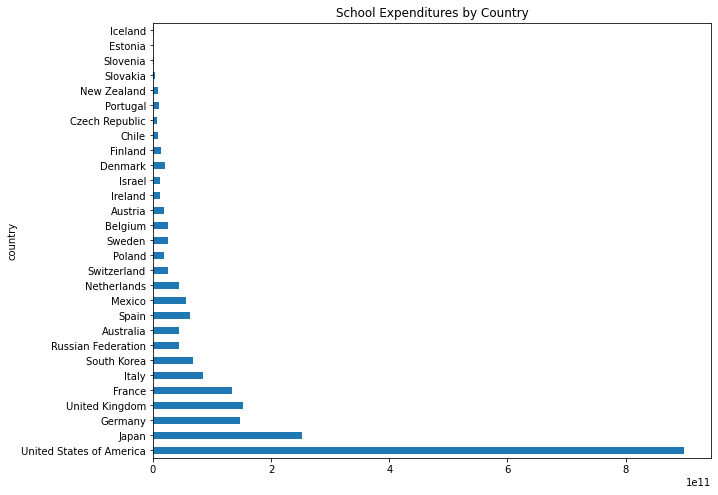

In [99]:
import matplotlib
import matplotlib.pyplot as plt

ax = df_all_edu_1.plot.barh(x='country', y='school_expenditures', figsize = (10,8), title = "School Expenditures by Country", legend = False)